In [ ]:
import aiohttp, http, asyncio, requests, re, time, os
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pickle
import json
import steam_tags_f as stf

In [ ]:
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_colwidth', 16)

In [ ]:
%load_ext autoreload
%autoreload 2 

GETTING THE TAGS AND MULTIPLAYER INFO

In [ ]:
url = "http://api.steampowered.com/ISteamApps/GetAppList/v2/"

token = "1AC3575ADB761319F3EF72D1FA362232"

params = {"key":token}
response = requests.get(url, params=params)

data = response.json()

app_dict = {app['name']: app['appid'] for app in data['applist']['apps']}


In [ ]:
top1000 = pd.read_csv('TOP 1000 Games cleaned.csv')

In [ ]:
top1000["APP ID"] = 0

In [ ]:
#top1000_2 = stf.add_appid(top1000,app_dict)

In [ ]:
#top1000.to_csv('TOP 1000 Games cleaned AppId.csv', index=False)

In [ ]:
#manually entered some app-ids that were not fetched
appid_fix = pd.read_csv('top_1000_games_cleaned_appid_fix.csv')

In [ ]:
appid_fix

In [ ]:
txt = pd.read_csv(r"top_1000_games_cleaned_appid_fix.csv")
txt = txt.rename({"Game Title":"title", "Steam App ID":"id"}, axis=1)
appid_list = list(txt["id"])

In [ ]:
# Example
appid = 2923300

# Step 1: Make a request to the Steam API
response = requests.get(f"http://store.steampowered.com/api/appdetails?appids={appid}")

# Step 2: Parse the response
game = response.json()

#Step 3: Pretty-print the JSON response for better readability
print(json.dumps(game, indent=4))  # Format with indentation of 4 spaces


In [ ]:
genres = game["2923300"]["data"]["genres"]
descriptions = [genre["description"] for genre in genres]
print (descriptions)

In [ ]:
result = stf.check_multiplayer_single("1599340")
print(result) 

In [ ]:
#tag_dict = stf.get_tags(appid_list)

In [ ]:
with open ("tag_dict.pkl", "rb") as tag_dict_file:
    tag_dict = pickle.load(tag_dict_file)


In [ ]:
tag_dict

In [ ]:
appid_fix["tags"] = 0

#steam_df_tags = stf.add_tags(appid_fix,tag_dict)

In [ ]:
with open ("steam_df_tags.pkl", "rb") as steam_df_tags_file:
    steam_df_tags = pickle.load(steam_df_tags_file)

steam_df_tags

In [ ]:
#steam_df_tags.to_csv('steam_appid_tags.csv', index=False)

In [ ]:
token = "1AC3575ADB761319F3EF72D1FA362232"

In [ ]:
#mp_dict = stf.check_multiplayer(appid_list, token, delay=1)

In [ ]:
with open ("mp_dict.pkl", "rb") as mp_dict_file:
    mp_dict = pickle.load(mp_dict_file)

mp_dict

In [ ]:
steam_df_tags_mp = stf.add_mp(steam_df_tags, mp_dict)

In [ ]:
steam_df_tags_mp

In [ ]:
steam_df_tags_mp.to_csv('steam_appid_tags_mp.csv', index=False)

FUNCTIONS

In [ ]:
def get_url(url, headers=None, params=None):
    
    response = requests.get(url,headers=headers, params=params)
    stat = response.status_code
    soup = BeautifulSoup(response.content, 'html.parser')
    time.sleep(1)
    
    return stat, soup

def fetch_dict(soup, gameid):
    k_value = 0
    players = soup.find("tbody")
    play = re.split(r"[\n\t]+",players.get_text().strip())
    player_game = {} 

    for i in range(0, len(play), 5):
        # Date
        date = play[i]
        # Peak players
        peak = play[i+1]  
        # Average players
        average = play[i +4]
        player_game[k_value]={"Date": date,
                            "Peak Players":peak,
                            "Avg Players":average,
        }
        
        k_value += 1
        
    return player_game

def overall_fetch(list_id):
    error_list =[]
    game_id_dict = {}
    for gameid in list_id:
        gameid = str(gameid)
        url = f'https://steamcharts.com/app/{gameid}'
        headers= {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36'}
        try:
            stat, soup = get_url(url, headers=headers, params=gameid)
            if stat == 200:
                print(f"Webcode status is : {stat} for {gameid} id. ")
                player_game = fetch_dict(soup, gameid)
                game_id_dict[gameid] = player_game.copy()
            else:
                error_list.append((gameid, stat))
                print(f"Appid: {gameid} reported an error {stat}, skipping it for now")    
        except Exception as e:  # Catch specific exceptions
            error_list.append((gameid, stat))
            print(f"App ID: {gameid} reported an error: {str(e)}, skipping it for now.")
            
    
    return game_id_dict, error_list

MAIN CODES

In [ ]:
# creates the games id list
txt = pd.read_csv(r"C:\\Users\\Utilizador\\Desktop\\IRONHACK\\Project 3\\Project-3\\top1k.csv")
txt = txt.rename({"Game Title":"title", "Steam App ID":"id"}, axis=1)
list_id = list(txt["id"])

In [ ]:
## main program, output

game_id_dict, error_list = overall_fetch(list_id)

In [ ]:
# Saves our main source of information into a feather
output = pd.DataFrame.from_dict(game_id_dict)
output.to_feather("output.feather")

In [ ]:
# Saves our error results into an error csv
err_table = pd.DataFrame(error_list)
err_table.to_csv("error.csv")

In [121]:
### Bridges the webscrapping/API part with the cleaning and processing parts

# imports our feather database & gives us an idea of the shape/NaN's present
output = pd.read_feather("C:\\Users\\Utilizador\\Desktop\\IRONHACK\\Project 3\\Project-3\\output.feather")
output.isna().sum()
display(output.shape)

(147, 849)

In [122]:
# Cleans database of most recent games (so from Aug 2019 -> Present)
out2 = output.copy() 
filtered = out2.isna().sum(axis=0) > 85 ## 85 = Aug 2019
filter = filtered[filtered]

mask = list(filter.index)
for code in mask:
    out2.drop(code, axis = 1, inplace=True)

In [123]:
# Converts "Date" into DataFrame index
out3=out2.copy()
out2_extracted = out2.applymap(lambda x: x["Date"] if isinstance(x, dict) else x) 

out3["Date"] = out2_extracted["730"]
out3.set_index('Date', inplace=True)

out3_extracted = out3.applymap(lambda x: x["Avg Players"] if isinstance(x, dict) else x)
out3_extracted

,578080,730,570,105600,377160,532210,945360,232770,552990,...,224600,209650,324800,446800,67370,113200,226320,544920,805550
Date,,,,,,,,,,,,,,,,,,,
Last 30 Days,807515,1473144,726385,41618,28436,561,10881,43,16956,...,4,107,283,240,49,394,5,23,5131
August 2024,719506,1425958,734381,40217,34798,561,10069,52,11547,...,3,105,1050,223,49,368,4,21,4825
July 2024,700235,1342171,801126,45909,37963,1166,10133,58,10814,...,5,110,417,199,56,337,4,19,5738
June 2024,699256,1510840,869492,47813,80807,531,9699,51,15742,...,4,118,699,230,56,346,5,21,6575
May 2024,693105,1614925,943059,42890,167779,390,7772,55,75380,...,4,117,284,250,44,335,5,21,7650
April 2024,699697,1618685,921133,51130,186746,292,9052,57,12690,...,5,146,834,233,48,424,4,17,12290
March 2024,764034,1521796,729865,50825,25580,406,8569,54,11840,...,4,97,471,274,82,444,3,21,6069
February 2024,609366,1347519,741290,41641,24354,2094,8987,51,15103,...,3,109,424,293,164,394,6,21,7183
January 2024,587152,1277907,736488,54281,24668,407,11448,50,12653,...,6,112,923,319,52,470,6,21,7276


In [124]:
# Converts columns into game's name
out4 = out3.copy()
# creates the id list
txt2 = txt.rename({"Game Title":"title", "Steam App ID":"id"}, axis=1)
txt2 = txt2[["id","title"]]
txt2.set_index("id", inplace=True)

# Create a mapping from ids to titles
title_mapping = {str(k): v for k, v in txt2["title"].to_dict().items()}

# Rename the columns in out4 using the mapping
out4.columns = [title_mapping.get(str(col), col) for col in out4.columns]

# Creates our main dataframe visualization 
visual = "Peak Players"
out4 = out4.applymap(lambda x: x[visual] if isinstance(x, dict) else x)
out4 = round(out4.fillna(0).astype(float),0).astype(int)
out4

,PUBG: BATTLEGROUNDS,Counter-Strike 2,Dota 2,Terraria,Fallout 4,Life is Strange 2,Among Us,POSTAL,World of Warships,...,Defiance,Call of Duty: Advanced Warfare,Shadow Warrior 2,Transport Fever,The Darkness II,The Binding of Isaac,Marvel Heroes Omega,Darwin Project,Assetto Corsa Competizione
Date,,,,,,,,,,,,,,,,,,,
Last 30 Days,295697,857185,430067,22757,14961,212,4754,23,7689,...,2,46,101,110,23,220,2,3,2207
August 2024,285247,897338,449798,26699,19942,228,5254,23,6550,...,1,53,180,111,23,217,1,4,2233
July 2024,293397,875365,475394,31317,21889,255,5217,28,6095,...,2,54,135,108,26,234,1,5,2499
June 2024,287499,947521,486674,29747,35491,222,4637,27,7213,...,2,57,132,112,20,219,2,5,2810
May 2024,271364,958207,512919,24491,76865,175,3759,27,8219,...,2,48,94,125,20,203,2,4,3106
April 2024,280853,930749,456551,27617,59102,147,3816,27,6492,...,2,56,175,119,20,243,1,4,3833
March 2024,281342,885630,428919,26285,14791,159,3953,22,6399,...,2,46,126,131,32,258,1,4,2578
February 2024,250315,786631,427922,25216,14589,172,4141,24,7885,...,1,60,133,135,34,241,2,4,2719
January 2024,249558,760859,440229,32927,15334,177,4689,25,7234,...,2,51,208,154,23,291,1,5,2736


In [125]:
# More cleaning while looking at data. Disregarding outliers etc..
out5 = out4.copy()

## Drops useless games that make weird spikes
out5.drop("POSTAL", axis=1, inplace=True)

# Creates a new column (Total) and concats into the existing dataframe
total_column = out5.sum(axis = 1)
out5 = pd.concat([out5, total_column.rename("Total")], axis=1)

In [126]:
# Normalization 1 (average gains) - Assuming 'Total' is the column you want to apply the formula to
out5['Value'] = (out5['Total'] - out5['Total'].shift(-1)) / out5['Total']
display(out5)
#display(txt2)

,PUBG: BATTLEGROUNDS,Counter-Strike 2,Dota 2,Terraria,Fallout 4,Life is Strange 2,Among Us,World of Warships,Grand Theft Auto V,...,Shadow Warrior 2,Transport Fever,The Darkness II,The Binding of Isaac,Marvel Heroes Omega,Darwin Project,Assetto Corsa Competizione,Total,Value
Date,,,,,,,,,,,,,,,,,,,
Last 30 Days,295697,857185,430067,22757,14961,212,4754,7689,101477,...,101,110,23,220,2,3,2207,3429549,-0.066645
August 2024,285247,897338,449798,26699,19942,228,5254,6550,116181,...,180,111,23,217,1,4,2233,3658113,-0.026784
July 2024,293397,875365,475394,31317,21889,255,5217,6095,115604,...,135,108,26,234,1,5,2499,3756092,0.011234
June 2024,287499,947521,486674,29747,35491,222,4637,7213,102804,...,132,112,20,219,2,5,2810,3713895,0.001055
May 2024,271364,958207,512919,24491,76865,175,3759,8219,92748,...,94,125,20,203,2,4,3106,3709978,-0.006311
April 2024,280853,930749,456551,27617,59102,147,3816,6492,95409,...,175,119,20,243,1,4,3833,3733392,0.012341
March 2024,281342,885630,428919,26285,14791,159,3953,6399,104564,...,126,131,32,258,1,4,2578,3687320,0.072988
February 2024,250315,786631,427922,25216,14589,172,4141,7885,108198,...,133,135,34,241,2,4,2719,3418189,-0.049915
January 2024,249558,760859,440229,32927,15334,177,4689,7234,123806,...,208,154,23,291,1,5,2736,3588807,0.019489


In [127]:
# further normalizations - Z score normalization
def z_norm(column):
    mean = column.mean()
    std_dev = column.std()
    return (column - mean) / std_dev

out5['Z'] = z_norm(out5['Total'])

out5

,PUBG: BATTLEGROUNDS,Counter-Strike 2,Dota 2,Terraria,Fallout 4,Life is Strange 2,Among Us,World of Warships,Grand Theft Auto V,...,Transport Fever,The Darkness II,The Binding of Isaac,Marvel Heroes Omega,Darwin Project,Assetto Corsa Competizione,Total,Value,Z
Date,,,,,,,,,,,,,,,,,,,
Last 30 Days,295697,857185,430067,22757,14961,212,4754,7689,101477,...,110,23,220,2,3,2207,3429549,-0.066645,1.018696
August 2024,285247,897338,449798,26699,19942,228,5254,6550,116181,...,111,23,217,1,4,2233,3658113,-0.026784,1.244366
July 2024,293397,875365,475394,31317,21889,255,5217,6095,115604,...,108,26,234,1,5,2499,3756092,0.011234,1.341105
June 2024,287499,947521,486674,29747,35491,222,4637,7213,102804,...,112,20,219,2,5,2810,3713895,0.001055,1.299442
May 2024,271364,958207,512919,24491,76865,175,3759,8219,92748,...,125,20,203,2,4,3106,3709978,-0.006311,1.295575
April 2024,280853,930749,456551,27617,59102,147,3816,6492,95409,...,119,20,243,1,4,3833,3733392,0.012341,1.318692
March 2024,281342,885630,428919,26285,14791,159,3953,6399,104564,...,131,32,258,1,4,2578,3687320,0.072988,1.273203
February 2024,250315,786631,427922,25216,14589,172,4141,7885,108198,...,135,34,241,2,4,2719,3418189,-0.049915,1.007480
January 2024,249558,760859,440229,32927,15334,177,4689,7234,123806,...,154,23,291,1,5,2736,3588807,0.019489,1.175938


(array([31., 59.]),
 [Text(31.0, 0, 'February 2022'), Text(59.0, 0, 'October 2019')])

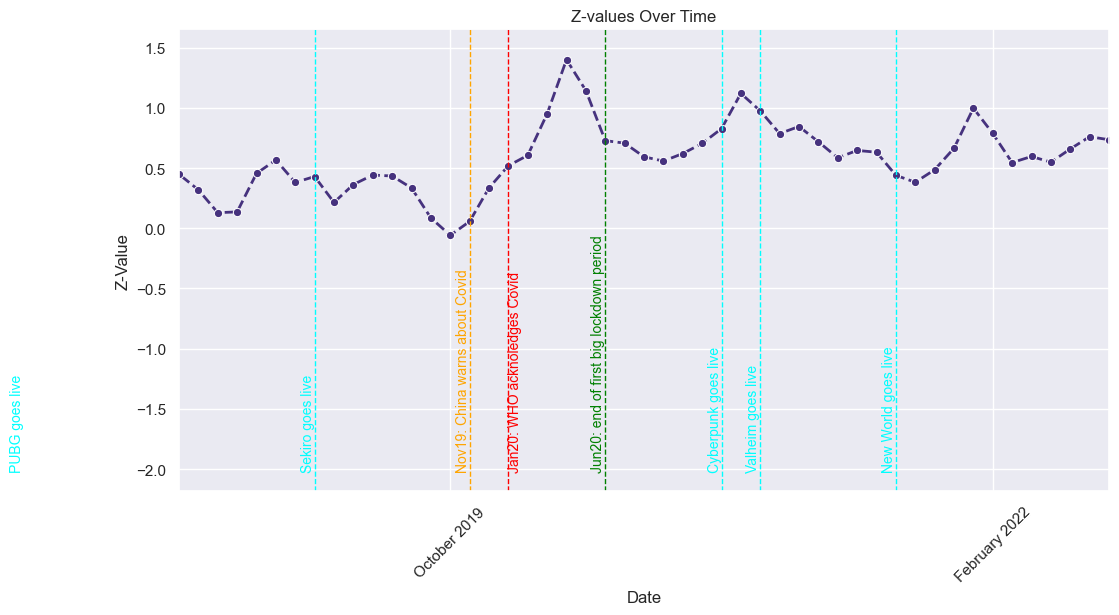

In [134]:
## Data Visualization 

# Set theme and palette
sns.set_theme(style="darkgrid")
sns.set_palette("viridis")

# Create a line plot for Total values over Date
plt.figure(figsize=(12, 6))  # Adjust figure size
sns.lineplot(data=out5, x=out5.index, y='Z', marker='o', linestyle='--', linewidth=2)

#### Add a vertical line on a specific date

# Covid related lines
plt.axvline(x="November 2019", color='orange', linestyle='--', linewidth=1)
plt.axvline(x="January 2020", color='red', linestyle='--', linewidth=1)
plt.axvline(x="June 2020", color='green', linestyle='--', linewidth=1)

plt.text(x="November 2019", y=-2,  s='Nov19: China warns about Covid', color='orange', fontsize=10, ha='right', rotation=90)
plt.text(x="January 2020", y=-2, s='Jan20: WHO acknoledges Covid', color='red', fontsize=10, ha='left', rotation=90)
plt.text(x="June 2020", y=-2, s='Jun20: end of first big lockdown period', color='green', fontsize=10, ha='right', rotation=90)

# Game related lines
plt.axvline(x="December 2017", color='cyan', linestyle='--', linewidth=1)
plt.axvline(x="December 2020", color='cyan', linestyle='--', linewidth=1)
plt.axvline(x="September 2021", color='cyan', linestyle='--', linewidth=1)
plt.axvline(x="February 2021", color='cyan', linestyle='--', linewidth=1)
plt.axvline(x="March 2019", color='cyan', linestyle='--', linewidth=1)


plt.text(x="December 2017", y=-2, s="PUBG goes live", color='cyan', fontsize=10, ha='right', rotation=90)
plt.text(x="December 2020", y=-2, s="Cyberpunk goes live", color='cyan', fontsize=10, ha='right', rotation=90)
plt.text(x="September 2021", y=-2, s="New World goes live", color='cyan', fontsize=10, ha='right', rotation=90)
plt.text(x="February 2021", y=-2, s="Valheim goes live", color='cyan', fontsize=10, ha='right', rotation=90)
plt.text(x="March 2019", y=-2, s="Sekiro goes live", color='cyan', fontsize=10, ha='right', rotation=90)

### Graphic formatting

# Format the date on the x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

#Limit x-axis onto a specific interval 
plt.xlim('August 2022', 'August 2018')  # Specify the limits as strings
plt.gca().invert_xaxis() # inverts the x-axis (more suited for dates as it grows from left to right)

# Set titles and labels
plt.title('Z-values Over Time')
plt.xlabel('Date')
plt.ylabel('Z-Value')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability